# Basic depth map processing

In [1]:
import cv2
from pathlib import Path
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from IPython.display import clear_output
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from torchinfo import summary
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split
import numpy as np

def seed_everything(seed=4242):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

### Visualization

In [2]:
label = 'adl' # fall, adl
sequence_number = random.randint(0, 40 if label == 'adl' else 30) + 1
selected_video = Path(f'../datasets/{label}/sequence-{sequence_number:02}')

frames = sorted(selected_video.glob('*.png'))

for frame_path in frames:

    gray = cv2.imread(str(frame_path), cv2.IMREAD_GRAYSCALE)
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    viridis = cv2.applyColorMap(gray, cv2.COLORMAP_VIRIDIS)
    viridis = cv2.cvtColor(viridis, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(viridis)

    clear_output(wait=True)
    plt.imshow(img)
    plt.title(f'{label.capitalize()} sequence #{sequence_number}')
    plt.axis('off')
    plt.show()

# Dataset

In [3]:
root = Path('../datasets')
out_root = Path('../data_viridis')

if not out_root.exists():
    out_root.mkdir(exist_ok=True)

    for cls in ['adl', 'fall']:
        for seq in (root / cls).iterdir():
            out_seq = out_root / cls / seq.name
            out_seq.mkdir(parents=True, exist_ok=True)

            for f in seq.glob('*.png'):
                gray = cv2.imread(str(f), cv2.IMREAD_GRAYSCALE)
                gray = cv2.resize(gray, (128, 128), interpolation=cv2.INTER_LINEAR)
                gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
                viridis = cv2.applyColorMap(gray, cv2.COLORMAP_VIRIDIS)
                viridis = cv2.cvtColor(viridis, cv2.COLOR_BGR2RGB)
                arr = np.array(viridis, dtype=np.uint8)
                np.save(out_seq / f'{f.stem}.npy', arr)


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None, number_of_frames=180):
        self.samples = []
        self.transform = transform
        self.number_of_frames = number_of_frames

        classes = ['adl', 'fall']
        for label_idx, cls in enumerate(classes):
            cls_path = Path(root_dir) / cls
            for seq_folder in cls_path.iterdir():
                if seq_folder.is_dir():
                    frames = sorted(seq_folder.glob('*.npy'))
                    if len(frames) > 0:
                        self.samples.append((frames, label_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_paths, label = self.samples[idx]
        T = len(frame_paths)

        if T >= self.number_of_frames:
            frame_paths = frame_paths[-self.number_of_frames:]
        else:
            pad = self.number_of_frames - T
            frame_paths = [frame_paths[0]] * pad + frame_paths

        imgs = []
        for f in frame_paths:
            arr = np.load(f)              # (H, W, 3), uint8
            img = Image.fromarray(arr)

            if self.transform:
                img = self.transform(img)

            imgs.append(img)

        video_tensor = torch.stack(imgs)  # (T, C, H, W)
        return video_tensor, label


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

dataset = VideoDataset(out_root, transform)

### Model

In [6]:
class CNN_LSTM(nn.Module):
    def __init__(self, hidden_size=256, num_classes=2):
        super(CNN_LSTM, self).__init__()
        
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # output: (B, 512, 1, 1)

        for param in self.cnn.parameters():
            param.requires_grad = False

        self.feature_dim = 512
        self.lstm = nn.LSTM(input_size=self.feature_dim, hidden_size=hidden_size, 
                          num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        '''
        x: (B, T, C, H, W)
        B = batch_size
        T = num_frames
        C = channels
        H = height
        W = width
        '''
        B, T, C, H, W = x.size()

        cnn_features = []
        for t in range(T):
            frame = x[:, t, :, :, :]        # (B, C, H, W)
            feat = self.cnn(frame)          # (B, 512, 1, 1)
            feat = feat.view(B, -1)         # (B, 512)
            cnn_features.append(feat)
        

        cnn_features = torch.stack(cnn_features, dim=1)

        lstm_out, _ = self.lstm(cnn_features) 

        last_time_step = lstm_out[:, -1, :] # (B, hidden_size)
        out = self.fc(last_time_step) # (B, num_classes)
        return out

In [7]:
model = CNN_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-4)

summary(model, input_size=(4, 256, 3, 128, 128), device=device)

Layer (type:depth-idx)                        Output Shape              Param #
CNN_LSTM                                      [4, 2]                    --
├─Sequential: 1-1                             [4, 512, 1, 1]            --
│    └─Conv2d: 2-1                            [4, 64, 64, 64]           (9,408)
│    └─BatchNorm2d: 2-2                       [4, 64, 64, 64]           (128)
│    └─ReLU: 2-3                              [4, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                         [4, 64, 32, 32]           --
│    └─Sequential: 2-5                        [4, 64, 32, 32]           --
│    │    └─BasicBlock: 3-1                   [4, 64, 32, 32]           (73,984)
│    │    └─BasicBlock: 3-2                   [4, 64, 32, 32]           (73,984)
│    └─Sequential: 2-6                        [4, 128, 16, 16]          --
│    │    └─BasicBlock: 3-3                   [4, 128, 16, 16]          (230,144)
│    │    └─BasicBlock: 3-4                   [4, 128, 16, 16]      

### Training

In [8]:
num_epochs = 10
batch_size = 4
num_folds = 10

g = torch.Generator()
g.manual_seed(42)
seed_everything(42)

indices = np.arange(len(dataset))
labels = np.array([dataset[i][1] for i in indices])

skf = StratifiedKFold(
    n_splits=num_folds,
    shuffle=True,
    random_state=42
)

checkpoint_dir = Path('../models/viridis_colormap')
checkpoint_dir.mkdir(exist_ok=True, parents=True)



========== FOLD 1/10 ==========
Epoch [1/10] TRAIN Loss: 0.6697 Acc: 63.49% | VAL Loss: 0.6476 Acc: 57.14% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4989 Acc: 92.06% | VAL Loss: 0.4453 Acc: 85.71% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3452 Acc: 95.24% | VAL Loss: 0.3778 Acc: 85.71% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.1391 Acc: 100.00% | VAL Loss: 0.1427 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1284 Acc: 98.41% | VAL Loss: 0.1865 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.0786 Acc: 98.41% | VAL Loss: 0.0894 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1578 Acc: 93.65% | VAL Loss: 0.1498 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.1380 Acc: 93.65% | VAL Loss: 0.0964 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.1785 Acc: 93.65% | VAL Loss: 0.2277 Acc: 100.00% | LR: 5.00e-05
Epoch [10/10] TRAIN Loss: 0.2027 Acc: 93.65% | VAL Loss: 0.1331 Acc: 100.00% | LR: 5.00e-05


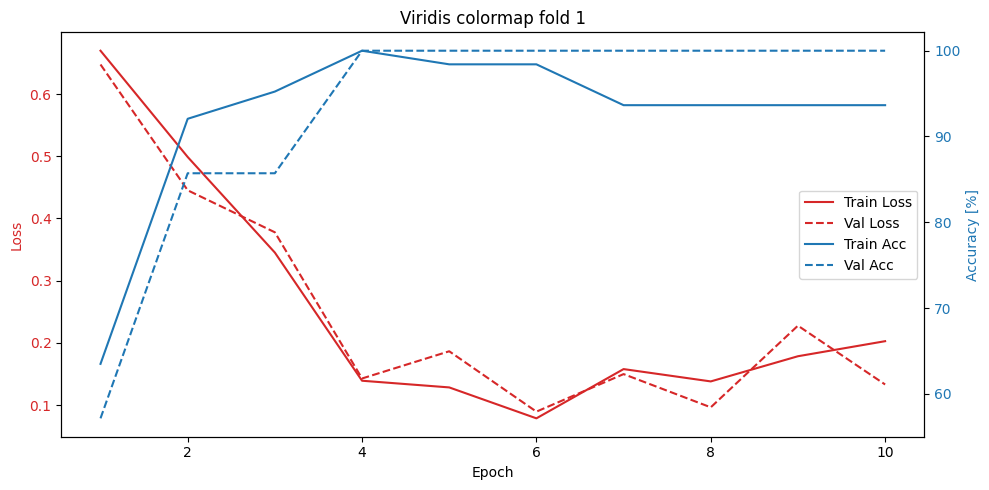


========== FOLD 2/10 ==========
Epoch [1/10] TRAIN Loss: 0.6372 Acc: 66.67% | VAL Loss: 0.5478 Acc: 57.14% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4433 Acc: 95.24% | VAL Loss: 0.3098 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.2472 Acc: 98.41% | VAL Loss: 0.1947 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.1938 Acc: 95.24% | VAL Loss: 0.1584 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2641 Acc: 90.48% | VAL Loss: 0.1302 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1189 Acc: 98.41% | VAL Loss: 0.1415 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.2086 Acc: 93.65% | VAL Loss: 0.2491 Acc: 85.71% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.2074 Acc: 92.06% | VAL Loss: 0.2275 Acc: 85.71% | LR: 5.00e-05
Epoch [9/10] TRAIN Loss: 0.2297 Acc: 90.48% | VAL Loss: 0.2806 Acc: 85.71% | LR: 5.00e-05
Epoch [10/10] TRAIN Loss: 0.2510 Acc: 85.71% | VAL Loss: 0.1642 Acc: 100.00% | LR: 5.00e-05


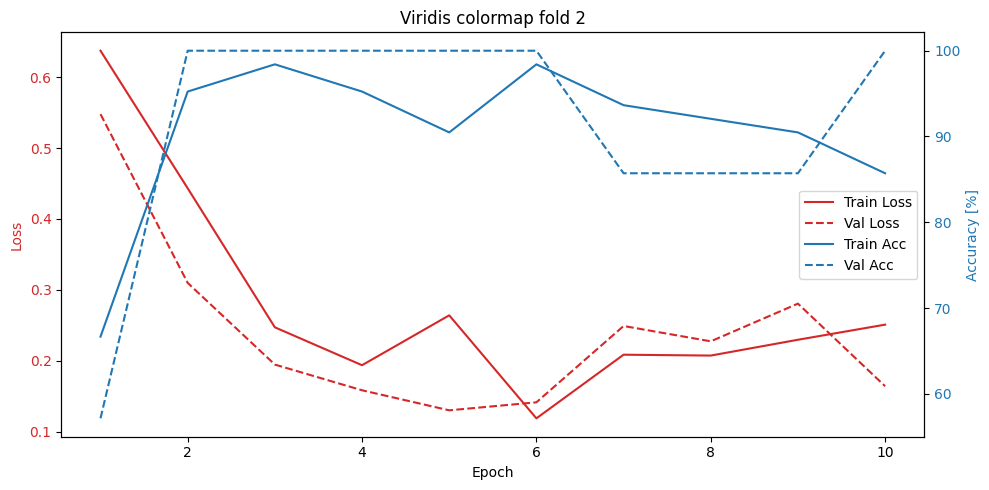


========== FOLD 3/10 ==========
Epoch [1/10] TRAIN Loss: 0.6194 Acc: 66.67% | VAL Loss: 0.5574 Acc: 100.00% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4477 Acc: 96.83% | VAL Loss: 0.4005 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.2769 Acc: 93.65% | VAL Loss: 0.2336 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.3501 Acc: 88.89% | VAL Loss: 0.1764 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1744 Acc: 96.83% | VAL Loss: 0.1377 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.2809 Acc: 84.13% | VAL Loss: 0.2426 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1052 Acc: 98.41% | VAL Loss: 0.1887 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.2894 Acc: 84.13% | VAL Loss: 0.1299 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.1100 Acc: 96.83% | VAL Loss: 0.0522 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.0964 Acc: 100.00% | VAL Loss: 0.1102 Acc: 100.00% | LR: 1.00e-04


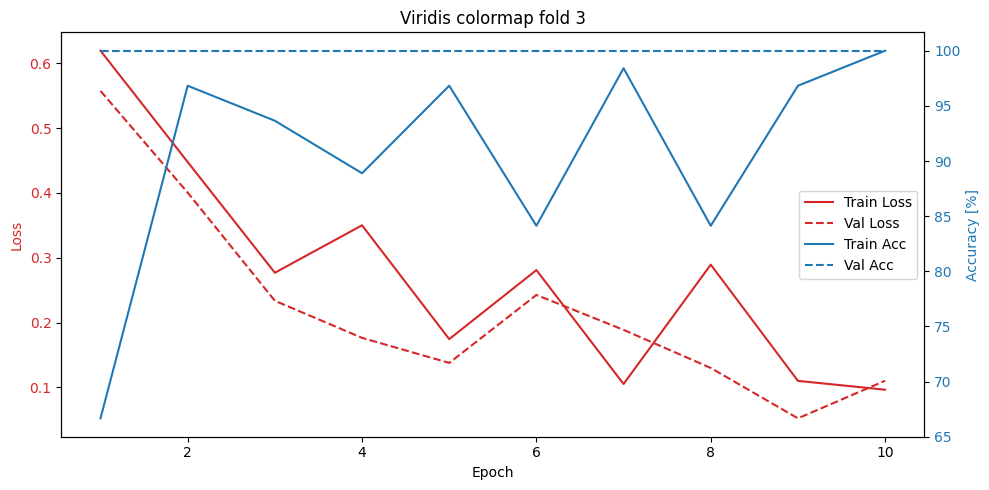


========== FOLD 4/10 ==========
Epoch [1/10] TRAIN Loss: 0.6032 Acc: 80.95% | VAL Loss: 0.4959 Acc: 57.14% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4155 Acc: 92.06% | VAL Loss: 0.2711 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.2302 Acc: 98.41% | VAL Loss: 0.1660 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.0922 Acc: 100.00% | VAL Loss: 0.1135 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.0335 Acc: 100.00% | VAL Loss: 0.1768 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.2352 Acc: 88.89% | VAL Loss: 0.2462 Acc: 85.71% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.0334 Acc: 100.00% | VAL Loss: 0.1448 Acc: 100.00% | LR: 5.00e-05
Epoch [8/10] TRAIN Loss: 0.0413 Acc: 100.00% | VAL Loss: 0.1041 Acc: 100.00% | LR: 5.00e-05
Epoch [9/10] TRAIN Loss: 0.1990 Acc: 90.48% | VAL Loss: 0.0446 Acc: 100.00% | LR: 5.00e-05
Epoch [10/10] TRAIN Loss: 0.0717 Acc: 98.41% | VAL Loss: 0.0439 Acc: 100.00% | LR: 5.00e-05


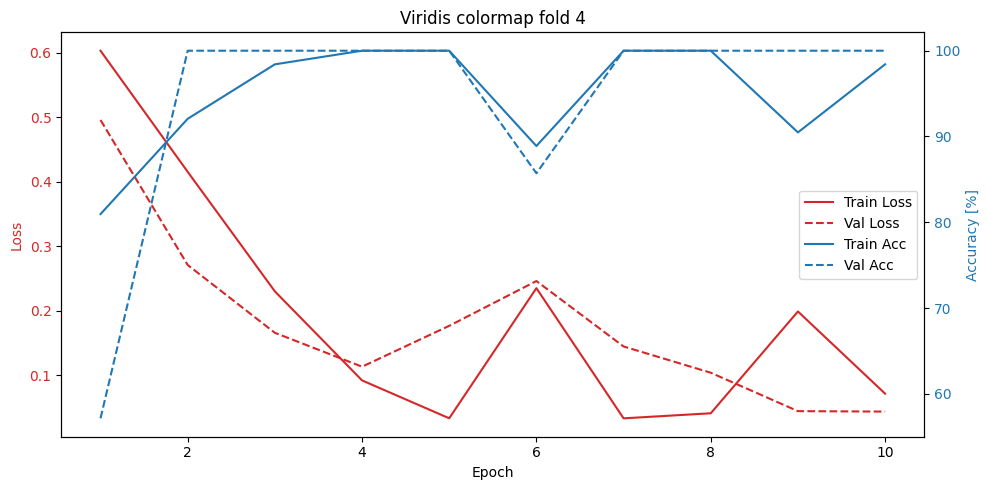


========== FOLD 5/10 ==========
Epoch [1/10] TRAIN Loss: 0.6472 Acc: 65.08% | VAL Loss: 0.6461 Acc: 57.14% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5293 Acc: 80.95% | VAL Loss: 0.4534 Acc: 71.43% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3883 Acc: 90.48% | VAL Loss: 0.4218 Acc: 71.43% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2895 Acc: 87.30% | VAL Loss: 0.2203 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1677 Acc: 95.24% | VAL Loss: 0.2912 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1312 Acc: 96.83% | VAL Loss: 0.1457 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.2001 Acc: 93.65% | VAL Loss: 0.0978 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.1171 Acc: 96.83% | VAL Loss: 0.0630 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.2679 Acc: 87.30% | VAL Loss: 0.1008 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.1484 Acc: 95.24% | VAL Loss: 0.2487 Acc: 85.71% | LR: 1.00e-04


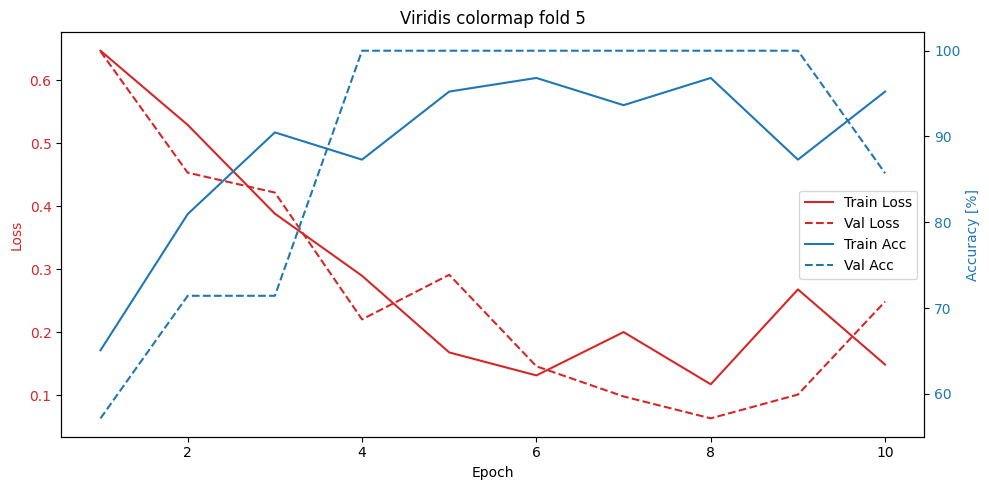


========== FOLD 6/10 ==========
Epoch [1/10] TRAIN Loss: 0.6598 Acc: 57.14% | VAL Loss: 0.5746 Acc: 71.43% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4695 Acc: 85.71% | VAL Loss: 0.4450 Acc: 85.71% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.4005 Acc: 84.13% | VAL Loss: 0.3143 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2604 Acc: 90.48% | VAL Loss: 0.3963 Acc: 85.71% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2250 Acc: 93.65% | VAL Loss: 0.1651 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1424 Acc: 95.24% | VAL Loss: 0.0918 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1089 Acc: 96.83% | VAL Loss: 0.0611 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.0679 Acc: 98.41% | VAL Loss: 0.1204 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.0774 Acc: 98.41% | VAL Loss: 0.0758 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.3716 Acc: 85.71% | VAL Loss: 0.0654 Acc: 100.00% | LR: 5.00e-05


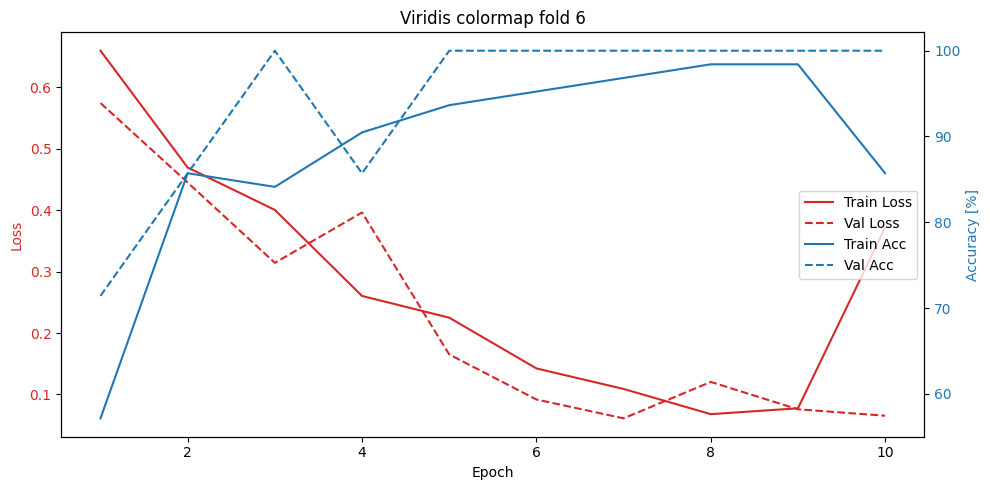


========== FOLD 7/10 ==========
Epoch [1/10] TRAIN Loss: 0.5980 Acc: 80.95% | VAL Loss: 0.5174 Acc: 71.43% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4305 Acc: 92.06% | VAL Loss: 0.3516 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.2546 Acc: 96.83% | VAL Loss: 0.2111 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.1157 Acc: 100.00% | VAL Loss: 0.2678 Acc: 85.71% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2234 Acc: 88.89% | VAL Loss: 0.2900 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.3971 Acc: 82.54% | VAL Loss: 0.2951 Acc: 100.00% | LR: 5.00e-05
Epoch [7/10] TRAIN Loss: 0.1552 Acc: 95.24% | VAL Loss: 0.2030 Acc: 100.00% | LR: 5.00e-05
Epoch [8/10] TRAIN Loss: 0.1820 Acc: 92.06% | VAL Loss: 0.2617 Acc: 100.00% | LR: 5.00e-05
Epoch [9/10] TRAIN Loss: 0.1924 Acc: 92.06% | VAL Loss: 0.1032 Acc: 100.00% | LR: 5.00e-05
Epoch [10/10] TRAIN Loss: 0.1280 Acc: 98.41% | VAL Loss: 0.5515 Acc: 57.14% | LR: 5.00e-05


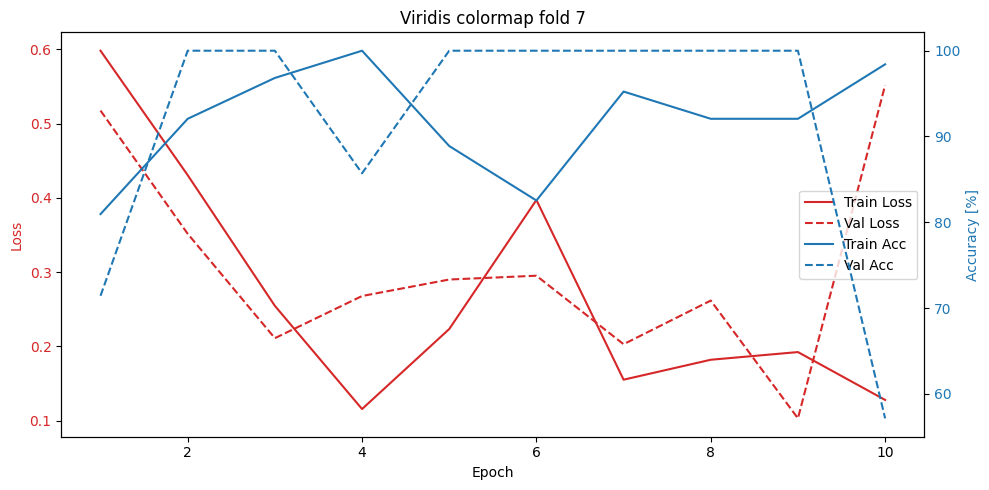


========== FOLD 8/10 ==========
Epoch [1/10] TRAIN Loss: 0.6531 Acc: 71.43% | VAL Loss: 0.5815 Acc: 100.00% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4553 Acc: 90.48% | VAL Loss: 0.3662 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3748 Acc: 88.89% | VAL Loss: 0.2943 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.1678 Acc: 98.41% | VAL Loss: 0.1344 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.0730 Acc: 100.00% | VAL Loss: 0.1745 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.2168 Acc: 92.06% | VAL Loss: 0.0729 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.0954 Acc: 98.41% | VAL Loss: 0.0878 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.0325 Acc: 100.00% | VAL Loss: 0.0931 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.0294 Acc: 100.00% | VAL Loss: 0.0421 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.0432 Acc: 98.41% | VAL Loss: 0.0908 Acc: 100.00% | LR: 1.00e-04


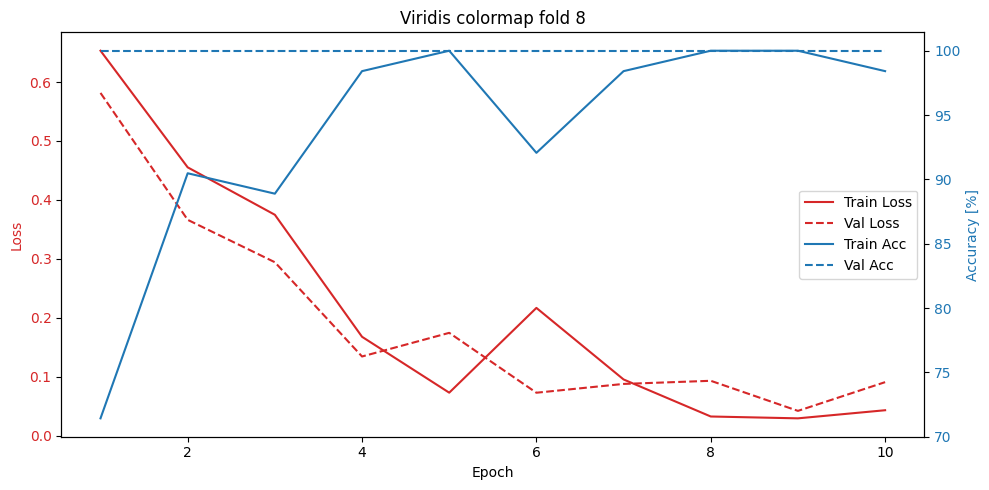


========== FOLD 9/10 ==========
Epoch [1/10] TRAIN Loss: 0.6074 Acc: 60.32% | VAL Loss: 0.4746 Acc: 100.00% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4680 Acc: 93.65% | VAL Loss: 0.3534 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3637 Acc: 87.30% | VAL Loss: 0.3872 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.3330 Acc: 87.30% | VAL Loss: 0.2510 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1654 Acc: 98.41% | VAL Loss: 0.1366 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.0552 Acc: 100.00% | VAL Loss: 0.1852 Acc: 85.71% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.0857 Acc: 98.41% | VAL Loss: 0.1280 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.1130 Acc: 98.41% | VAL Loss: 0.0848 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.1084 Acc: 96.83% | VAL Loss: 0.1019 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.0869 Acc: 98.41% | VAL Loss: 0.1787 Acc: 85.71% | LR: 1.00e-04


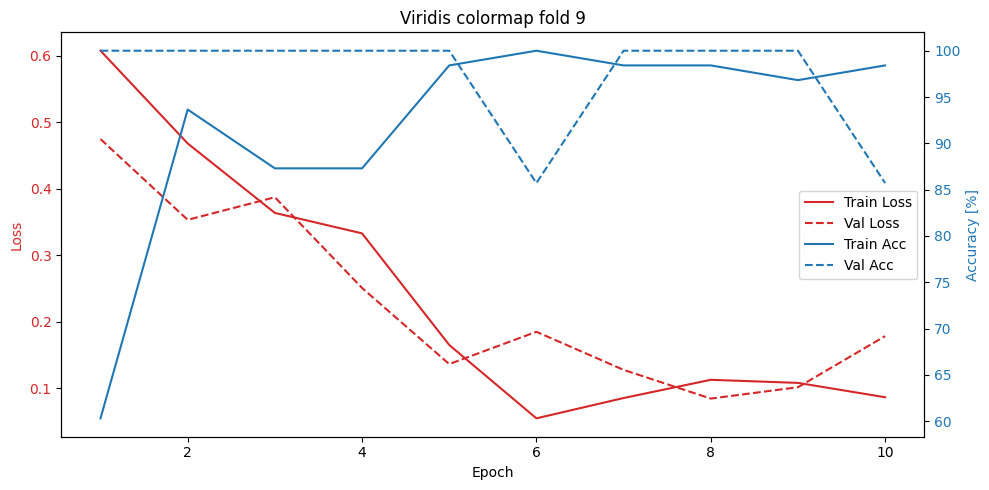


========== FOLD 10/10 ==========
Epoch [1/10] TRAIN Loss: 0.6348 Acc: 71.43% | VAL Loss: 0.5895 Acc: 100.00% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4600 Acc: 88.89% | VAL Loss: 0.4976 Acc: 57.14% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3082 Acc: 93.65% | VAL Loss: 0.2497 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.1837 Acc: 95.24% | VAL Loss: 0.1734 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1174 Acc: 96.83% | VAL Loss: 0.0932 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.3002 Acc: 87.30% | VAL Loss: 0.1571 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.2139 Acc: 92.06% | VAL Loss: 0.2672 Acc: 85.71% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.0656 Acc: 100.00% | VAL Loss: 0.1760 Acc: 100.00% | LR: 5.00e-05
Epoch [9/10] TRAIN Loss: 0.1382 Acc: 93.65% | VAL Loss: 0.0878 Acc: 100.00% | LR: 5.00e-05
Epoch [10/10] TRAIN Loss: 0.1168 Acc: 96.83% | VAL Loss: 0.0668 Acc: 100.00% | LR: 5.00e-05


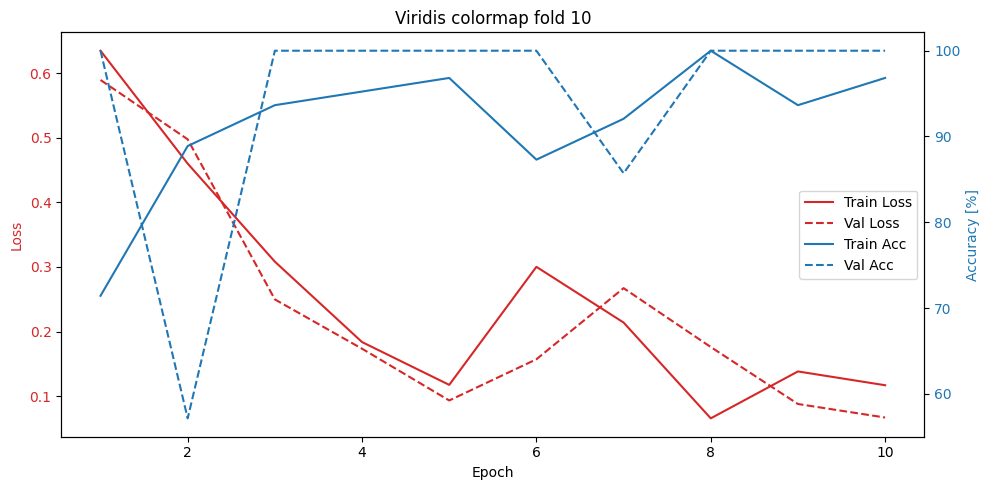

In [9]:
for fold, (train_idx, val_idx) in enumerate(skf.split(indices, labels)):
    print(f'\n========== FOLD {fold+1}/{num_folds} ==========')

    model = CNN_LSTM().to(device)
    optimizer = torch.optim.NAdam(model.parameters(), lr=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        generator=g
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    best_val_loss = 1e10
    best_model_path = checkpoint_dir / f'best_model_fold_{fold}.pt'

    # ===== HISTORIA =====
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # ===================== TRAIN =====================
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for videos, y in train_loader:
            videos = videos.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * videos.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss /= len(train_dataset)
        train_acc = 100 * correct / total

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # ===================== VAL =====================
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for videos, y in val_loader:
                videos = videos.to(device)
                y = y.to(device)

                outputs = model(videos)
                loss = criterion(outputs, y)

                val_loss += loss.item() * videos.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        val_loss /= len(val_dataset)
        val_acc = 100 * correct / total

        scheduler.step(val_loss)

        val_losses.append(val_loss)
        val_accs.append(val_acc)
        current_lr = optimizer.param_groups[0]['lr']

        print(
            f'Epoch [{epoch+1}/{num_epochs}] '
            f'TRAIN Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | '
            f'VAL Loss: {val_loss:.4f} Acc: {val_acc:.2f}% | '
            f'LR: {current_lr:.2e}'
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    # ===================== PLOT =====================
    epochs = range(1, num_epochs + 1)
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, train_losses, label='Train Loss', color='tab:red')
    ax1.plot(epochs, val_losses, label='Val Loss', color='tab:red', linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy [%]', color='tab:blue')
    ax2.plot(epochs, train_accs, label='Train Acc', color='tab:blue')
    ax2.plot(epochs, val_accs, label='Val Acc', color='tab:blue', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')
    plt.title(f'Viridis colormap fold {fold+1}')
    plt.tight_layout()
    plt.show()



========== FINAL EVAL: EACH FOLD MODEL ON FULL DATASET ==========

Fold 1:
Errors:
fall/sequence-07


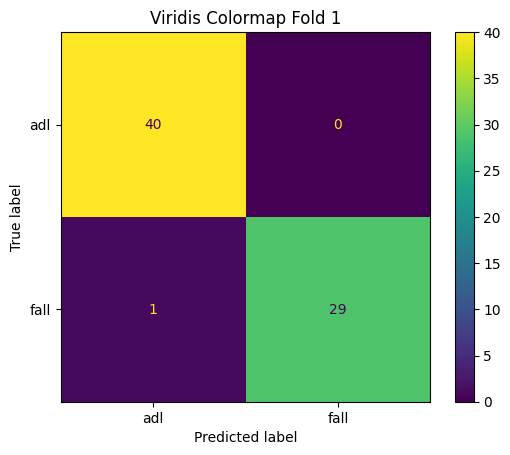

{'fold': 0, 'acc': 0.9857142857142858, 'prec': 1.0, 'rec': 0.9666666666666667, 'f1': 0.9830508474576272}

Fold 2:
{'fold': 1, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 3:
{'fold': 2, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 4:
{'fold': 3, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 5:
{'fold': 4, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 6:
{'fold': 5, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 7:
{'fold': 6, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 8:
{'fold': 7, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 9:
{'fold': 8, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 10:
{'fold': 9, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}


In [16]:
print('\n========== FINAL EVAL: EACH FOLD MODEL ON FULL DATASET ==========')

final_results = []

full_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    generator=g
)

for fold in range(num_folds):
    model_path = checkpoint_dir / f'best_model_fold_{fold}.pt'
    print(f'\nFold {fold+1}:')

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        error_fragments = []
        for batch_idx, (videos, y) in enumerate(full_loader):
            videos = videos.to(device)
            y = y.to(device)

            outputs = model(videos)
            _, preds = torch.max(outputs, 1)

            incorrect_idx = (preds != y).nonzero(as_tuple=True)[0]

            start_idx = batch_idx * full_loader.batch_size
            global_incorrect_idx = start_idx + incorrect_idx

            for idx in global_incorrect_idx:
                full_path = full_loader.dataset.samples[idx.item()][0]
                full_path_str = str(full_path)
                parts = full_path_str.split('/')[-3:-1]
                fragment = '/'.join(parts)
                error_fragments.append(fragment)


            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    if error_fragments:
        print("Errors:")
        for f in error_fragments:
            print(f)
        
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=['adl', 'fall']
        )

        disp.plot()
        plt.title(f'Viridis Colormap Fold {fold+1}')
        plt.show()

    metrics = {
        'fold': fold,
        'acc': accuracy_score(all_labels, all_preds),
        'prec': precision_score(all_labels, all_preds, average='binary'),
        'rec': recall_score(all_labels, all_preds, average='binary'),
        'f1': f1_score(all_labels, all_preds, average='binary'),
    }

    final_results.append(metrics)
    print(metrics)


In [12]:
print('\n========== CV RESULTS ==========')

for metric in final_results[0].keys():
    if metric == 'fold':
        continue
    values = [f[metric] for f in final_results]
    print(
        f'{metric.upper()}: '
        f'{np.mean(values)*100:.2f}% std: {np.std(values)*100:.2f}%'
    )



========== CV RESULTS ==========
ACC: 99.86% std: 0.43%
PREC: 100.00% std: 0.00%
REC: 99.67% std: 1.00%
F1: 99.83% std: 0.51%
